In [25]:
# Think about what 'exact linear solution' means for the PDE. It is a sine function
#
# Calculate the relative eror and RMSE at each grid point!
#
# Use static boundary conditions
#
# Consider very small time integrations (only 5, 10 steps, etc... the periodicity is the error in the long term!)
# For two time steps, small truncation error in u should be observed
# Consider u FDE vs u PDE in making sure the solution is correct

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')
plt.rcParams.update({'font.size': 18})

## Calculate basic FDE and plot

CFL:  0.005999999999999999


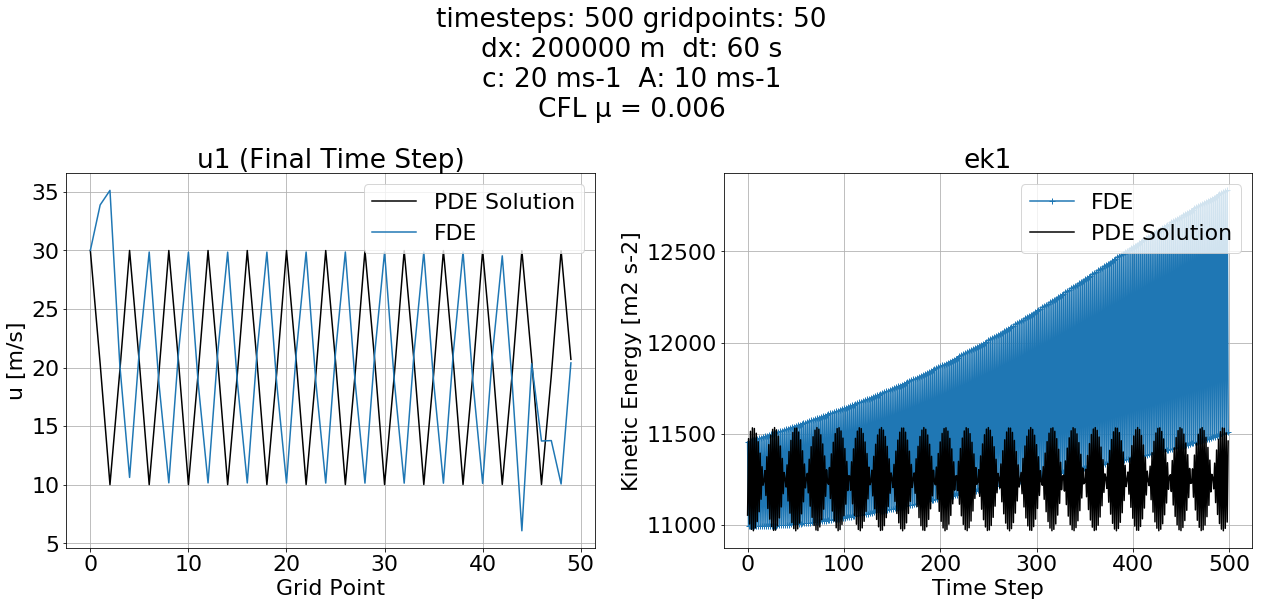

In [33]:
# Establish constants
pi = 3.14

dx = 200 * 1e3 # m 
dt = 60. # s

c = 20. # ms-1
A = 10. # ms-1

L = 4. * dx
k = (2. * pi) / L

m = 500 # number of time steps
n = 50 # number of grid points

# For stability: 0 < mu < 1
mu = c * (dt / dx)
print('CFL: ', mu)

u1 = np.zeros(shape=(m, n))

# Initial Conditions
u1[0, :] = c + (A * np.sin(k * dx * np.arange(1, n+1)))

# Boundary Conditions (Static)
u1[:, 0] = u1[0, 0]
u1[:, -1] = u1[0, -1]

# Calculate u1
# Initialize first step with Upstream Scheme
u1[1, 1:-2] = u1[0, 1:-2] - (c * dt * (u1[0, 1:-2] - u1[0, 0:-3]) / dx)

for i in range(2, m):
    for j in range(1, n-1):
        
        # Time Integrate with Leapfrog Scheme
        u1[i, j] = u1[i-2, j] - (c * dt * ( u1[i-1, j+1] - u1[i-1, j-1] ) / dx)
        
        # Time Integrate with Upstream Scheme
        # u1[i, j] = u1[i-1, j] - (c * dt * ( u1[i-1, j+1] - u1[i-1,j-1] ) / dx)
        
# Calculate Kinetic Energy at each time step
_ek1 = 0.5 * (u1**2)
ek1 = np.sum(_ek1, axis=1)

# Exact Solution
u = np.empty(u1.shape)
for t in range(m):
    for x in range(n):
        _x, _t, w = (x)*dx, (t)*dt, 1/c
        u[t, x] = c + (A * np.sin((w*_t) - (k*_x)))
        
# Calculate Kinetic Energy at each time step
_ek = 0.5 * (u**2)
ek = np.sum(_ek, axis=1)

# Create the plots
fig, axs = plt.subplots(1, 2, figsize=(18,18/2), facecolor='w')
fig.subplots_adjust(hspace=0.45, wspace=0.45)
axs = axs.flatten()
axs = [None, None, axs[0], axs[1]]

# axs[0].pcolormesh(u1.T)
# axs[0].set_xlabel('Time Step')
# axs[0].set_ylabel('Grid Point')
# axs[0].set_title('u1 Hovmoller')

# axs[1].pcolormesh(_ek1.T)
# axs[1].set_xlabel('Time Step')
# axs[1].set_ylabel('Grid Point')
# axs[1].set_title('ek1 Hovmoller')

axs[2].plot(u[-1, :], c='k', label='PDE Solution')
axs[2].plot(u1[-1, :], label='FDE')
axs[2].set_xlabel('Grid Point')
axs[2].set_ylabel('u [m/s]')
axs[2].set_title('u1 (Final Time Step)')
axs[2].legend(loc='upper right')

axs[3].plot(np.arange(len(ek1)), ek1, '-+', label='FDE')
axs[3].plot(np.arange(len(ek1)), ek, c='k', label='PDE Solution')
axs[3].set_xlabel('Time Step')
axs[3].set_ylabel('Kinetic Energy [m2 s-2]')
axs[3].set_title('ek1')
axs[3].legend(loc='upper right')

[ax.grid(True) for ax in axs[2:]]

configs = 'timesteps: %d gridpoints: %d\ndx: %d m  dt: %d s\nc: %d ms-1  A: %d ms-1\n'%(m, n, dx, dt, c, A)
fig.suptitle(configs + u"CFL \u03bc = %.3f"%mu)
fig.tight_layout(rect=[0, 0.03, 1, 0.8])
plt.show()

# Write kinetic energy at every 50th time step to file
with open('./ek1.csv', 'w+') as wfp:
    for t, v in zip(np.arange(1, m+1)[::-50][::-1], ek1[::-50][::-1]):
        wfp.write('%d, %f\n'%(t, v))

## Compare PDE exact solution with FDE for statistics

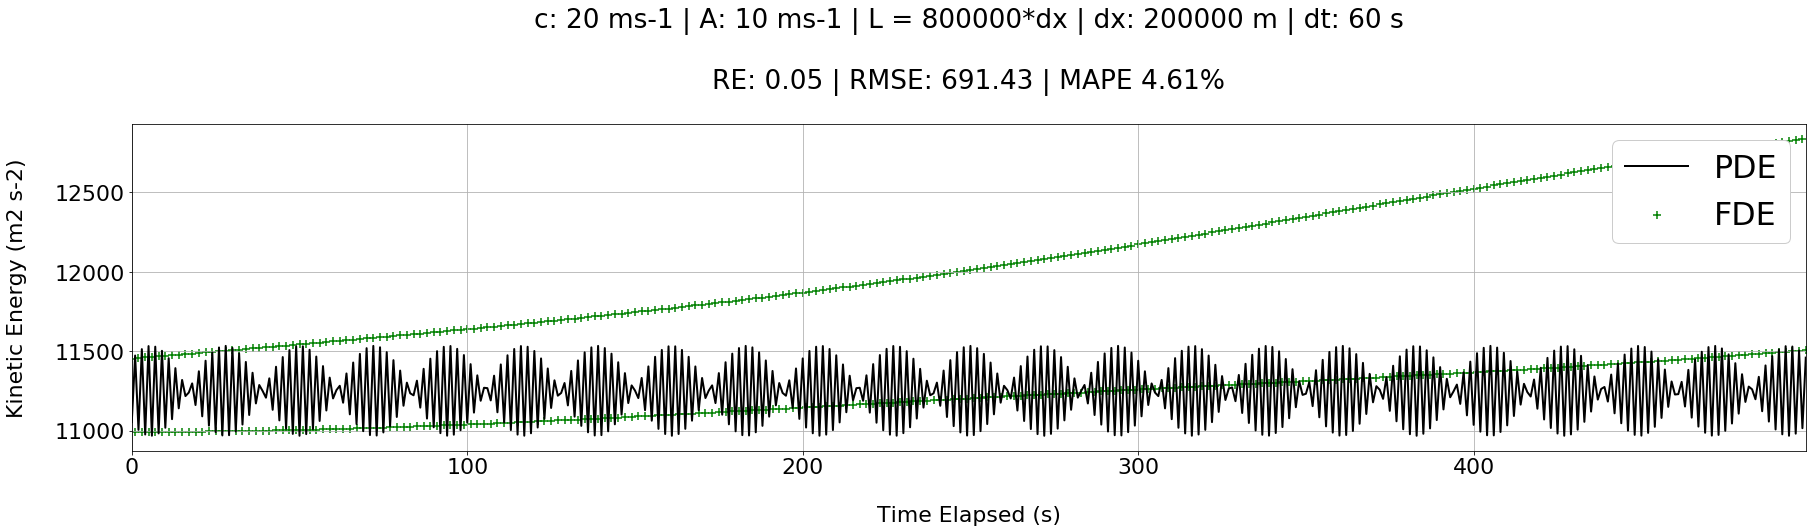

In [34]:
# Calculate Error Statistics
R = np.nanmean(abs(1 - (ek1 / ek)))
RMS = np.sqrt(np.nansum((ek1 - ek)**2/ek1.size))
MAPE = np.round((np.nansum(abs((ek - ek1) / ek)) / ek1.size) * 100, 2)

# Plot comparason
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(30,6))
t = np.arange(ek.size)

plt.scatter(t, ek1, marker='+', s=50, c='g', label='FDE')
plt.plot(t, ek, c='k', linewidth=2, label='PDE')

# plt.xlim([0, 2000000])
plt.xlabel('\nTime Elapsed (s)')
plt.ylabel('Kinetic Energy (m2 s-2)\n')
plt.xlim(0, t[-1])

plt.grid()
plt.legend(loc='upper right', fontsize='x-large', framealpha=1.)

config = 'c: %d ms-1 | A: %d ms-1 | L = %d*dx | dx: %d m | dt: %d s\n'%(c, A, L, dx, dt)
plt.title(config + '\nRE: %.2f | RMSE: %.2f | MAPE %.2f%%\n'%(R, RMS, MAPE))

# plt.ylim([10000, 12000])

plt.show()
